In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### PDF 기반 문서 검색기 (Retrieval chain) 생성

In [2]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드
pdf = PDFRetrievalChain(['data/SPRI_AI_Brief_2023년12월호_F.pdf']).create_chain()

pdf_retriever = pdf.retriever       # retriever 생성
pdf_chain = pdf.chain               # pdf retriever chain 생성

### State (상태 정의)

In [3]:
from typing import List
from typing_extensions import TypedDict, Annotated


class GraphState(TypedDict):
    """
    그래프의 상태를 나타내는 데이터 모델

    Attributes:
        question: 사용자 질문
        generation: LLM 생성된 답변
        documents: 도큐먼트 리스트
    """

    question: Annotated[str, "User question"]
    generation: Annotated[str, "LLM generated answer"]
    documents: Annotated[List[str], "List of documents"]

### PDF 기반 문서 검색기 (Retrieval chain) : 사용자 질문에 대한 PDF 문서를 검색

In [4]:
# 문서 검색 노드
def retrieve(state: GraphState):
    print('\n==========================================================================================')
    print(f"🔄 [Node] 문서 검색 노드 🔄")

    question = state['question']                    # 사용자 질문
    documents = pdf_retriever.invoke(question)      # 문서 검색
    
    print(f'문서 검색 결과: ')
    print(documents)
    
    print('==========================================================================================\n')
    
    return {'documents': documents}

In [5]:
state = GraphState(
    question='삼성전자가 만든 생성형 AI 이름은?',
    generation = '', 
    documents = []
)

In [6]:
answer = retrieve(state)                        # 사용자 질문에 대해서 관련 문서를 검색한다.
state['documents'] = answer['documents']


🔄 [Node] 문서 검색 노드 🔄
문서 검색 결과: 
[Document(id='251e1122-45f2-410a-a961-14d4cec657e5', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'), Document(id='cff7cf45-9696-41fa-bd95-5f775d893031', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:2

In [7]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='251e1122-45f2-410a-a961-14d4cec657e5', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='cff7cf45-9696-41fa-bd95-5f775d893031', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

### 사용자 질문에 대한 pdf 문서 검색 결과의 관련성을 평가하는 문서 검색 평가기(retrieval_grader) 노드

In [8]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from pydantic import BaseModel, Field


class GradeDocuments(BaseModel):                    # 문서 평가를 위한 데이터 모델
    """A binary score to determine the relevance of the retrieved document."""

    # 문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)


structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 프롬프트 정의
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""


# 프롬프트 템플릿
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)


# 사용자 질문에 대한 pdf 문서 검색 결과를 평가하는 문서 검색결과 평가기(retrieval_grader)
# 문서 검색 평가기는 사용자 질문과 검색 결과문서가 관련성이 있는지 본다
retrieval_grader = grade_prompt | structured_llm_grader

In [16]:
# 문서 검색 결과와 질문 관련성 평가 노드
def grade_documents(state: GraphState):
    print('\n==========================================================================================')
    print('===== [CHECK DOCUMENT RELEVANCE TO QUESTION] =====')

    question = state['question']            # 사용자 질문      
    documents = state['documents']          # 문서 검색 결과

    # 문서 검색 평가기를 통과한 문서들만 필터링
    filtered_docs = []

    for doc in documents:
        score = retrieval_grader.invoke({'question': question, 'document': doc.page_content})

        grade = score.binary_score     

        if grade == 'yes':
            print("---GRADE: DOCUMENT RELEVANT---")     
            filtered_docs.append(doc)                   
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---") 
            continue     

    print('==========================================================================================\n')

    return {'documents': filtered_docs}

In [17]:
return_documents = grade_documents(state)


===== [CHECK DOCUMENT RELEVANCE TO QUESTION] =====
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---



In [18]:
state['documents'] = return_documents['documents']

In [19]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'documents': [Document(id='251e1122-45f2-410a-a961-14d4cec657e5', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='cff7cf45-9696-41fa-bd95-5f775d893031', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Han

### 답변 생성을 위한 RAG 체인

In [20]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain import hub

# prompt = hub.pull("teddynote/rag-prompt")

template = """You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
Your primary mission is to answer questions based on provided context or chat history.
Ensure your response is concise and directly addresses the question without any additional narration.

###

Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

# Steps

1. Carefully read and understand the context provided.
2. Identify the key information related to the question within the context.
3. Formulate a concise answer based on the relevant information.
4. Ensure your final answer directly addresses the question.
5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the source cannot be found.

# Output Format:
[Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

**Source**(Optional)
- (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if you can't find the source of the answer.)
- (list more if there are multiple sources)
- ...

###

Remember:
- It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
- DO NOT use any external knowledge or information not present in the given materials.
- If you can't find the source of the answer, you should answer that you don't know.

###

# Here is the user's QUESTION that you should answer:
{question}

# Here is the CONTEXT that you should use to answer the question:
{context}

# Your final ANSWER to the user's QUESTION:"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )

output_parser = StrOutputParser()

# RAG 체인 생성 (pdf_retriever 문서 검색기를 사용해서 얻은 문서와 사용자 질문을 넣어서 결과)
rag_chain = prompt | llm | output_parser

### 답변 생성을 위한 RAG 체인을 실행하여 사용자 질문에 대한 답변을 생성하는 노드

In [21]:
# 답변 생성 노드
def generate(state: GraphState):
    print('\n==========================================================================================')
    print('🔄 [Node] 답변 생성 노드 🔄')

    # 사용자 질문
    question = state['question']  

    # 문서 검색 결과
    documents = state['documents']

    # RAG 실행 결과
    generation = rag_chain.invoke({'context': documents , 'question': 'question'})

    print(f'사용자 질문: {question}')
    print(f'문서 검색 결과:')
    print(documents)
    print()
    print(f'rag 실행 결과:')
    print(generation)
    print()
    print('==========================================================================================\n')    

    return {'generation': generation}

In [22]:
state['generation'] = generate(state)['generation']


🔄 [Node] 답변 생성 노드 🔄
사용자 질문: 삼성전자가 만든 생성형 AI 이름은?
문서 검색 결과:
[Document(id='251e1122-45f2-410a-a961-14d4cec657e5', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'), Document(id='cff7cf45-9696-41fa-bd95-5f775d893031', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.

In [23]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': "삼성전자가 공개한 생성 AI '삼성 가우스'는 언어, 코드, 이미지의 3개 모델로 구성되어 있으며, 온디바이스에서 작동하여 사용자 정보 유출 위험이 없다. 이 AI는 2023년 11월 8일 '삼성 AI 포럼 2023'에서 처음 소개되었다.\n\n**Source**\n- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)",
 'documents': [Document(id='251e1122-45f2-410a-a961-14d4cec657e5', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='cff7cf45-9696-41fa-bd95-5f775d893031', metadata={'so

### 답변의 할루시네이션 평가

In [24]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

class Groundednesss(BaseModel):
    """A binary score indicating whether the generated answer is grounded in the facts."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_hallucination_grader = llm.with_structured_output(Groundednesss)

# system
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""


# 프롬프트
groundedness_checking_prompt  = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
) 

# 답변에 대한 hallucination 평가기 생성
groundedness_grader = groundedness_checking_prompt | structured_hallucination_grader

### 답변의 관련성 평가

In [25]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

class GradeAnswer(BaseModel):
    """A binary score indicating whether the question is addressed."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

structured_llm_grader = llm.with_structured_output(GradeAnswer)

# system
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

# 프롬프트 템플릿
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 평가기를 결합하여 답변 평가기 생성
answer_grader = answer_prompt | structured_llm_grader

In [26]:
# Hallucination 평가 노드 (생성된 답변의 문서 및 질문과의 관련성 평가)
def grade_generation_v_documents_and_question(state: GraphState):           
    print('\n==========================================================================================')
    print(f'🔄 [Node] Hallucination 평가 노드 🔄')
    print("==== [CHECK HALLUCINATIONS] ====")
    
    qestion = state['question']         # 사용자 질문    
    documents = state['documents']      # 문서 검색 결과
    generation = state['generation']    # 생성된 답변

    # 평가
    score = groundedness_grader.invoke({'documents': documents, 'generation': generation})
    grade = score.binary_score

    print(f"===== [평가 결과] =====")
    print(grade)

    if grade == 'yes':      # hallucination 없음
        print("===== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] =====")
        print("no hallucination")

        # 답변에 대한 관련성 평가
        print("===== [GRADE GENERATED ANSWER vs QUESTION] =====")

        score = answer_grader.invoke({'question': state['question'], 'generation': generation})
        grade = score.binary_score

        if grade == 'yes':          # 관련성 있는 답변
            print("==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====")
            print("relevant")
            print('==========================================================================================\n')
            return "relevant"
        else:                       # 관련성 없는 답변
            print("==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====")
            print("not relevant")
            print('==========================================================================================\n')
            return "not relevant"

    else:                   # hallucination 있음
        print("===== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] =====")
        print("hallucination")
        print('==========================================================================================\n')
        return "hallucination"

In [27]:
grade_generation_v_documents_and_question(state)


🔄 [Node] Hallucination 평가 노드 🔄
==== [CHECK HALLUCINATIONS] ====
===== [평가 결과] =====
yes
===== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] =====
no hallucination
===== [GRADE GENERATED ANSWER vs QUESTION] =====
==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====
relevant



'relevant'

### 질문 재작성기(Question Rewriter)

In [28]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

# Query Rewriter 프롬프트
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_writer_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system), 
        ('human', 'Here is the initial question: \n\n {question} \n Formulate an improved question')
    ]
)

# Query Rewriter 생성
question_rewriter = re_writer_prompt | llm | StrOutputParser()

### Query Rewrite 노드

In [29]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Query Rewrite 노드
def transform_query(state: GraphState):
    print('\n==========================================================================================')
    print('===== [Node] 쿼리 재작성 노드 🔄 =====')

    # 사용자 질문
    question = state['question']

    # 문서 검색 결과
    documents = state['documents']

    
    # 쿼리 재작성
    better_question = question_rewriter.invoke({'question': question})
    print(f"better_question: {better_question}")
    print('==========================================================================================\n')

    return {'question': better_question}

In [30]:
state['question'] = transform_query(state)['question']


===== [Node] 쿼리 재작성 노드 🔄 =====
better_question: 삼성전자가 개발한 생성형 AI의 이름은 무엇인가요?



In [31]:
state

{'question': '삼성전자가 개발한 생성형 AI의 이름은 무엇인가요?',
 'generation': "삼성전자가 공개한 생성 AI '삼성 가우스'는 언어, 코드, 이미지의 3개 모델로 구성되어 있으며, 온디바이스에서 작동하여 사용자 정보 유출 위험이 없다. 이 AI는 2023년 11월 8일 '삼성 AI 포럼 2023'에서 처음 소개되었다.\n\n**Source**\n- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)",
 'documents': [Document(id='251e1122-45f2-410a-a961-14d4cec657e5', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='cff7cf45-9696-41fa-bd95-5f775d893031', metad

### 검색된 문서의 관련성 평가 결과에 따라 답변을 생성할 것인지 사용자 질문을 재작성 할 것인지 판단하는

In [33]:
def decide_to_generate(state: GraphState):
    print('\n==========================================================================================')
    print('🔄 [Node] 문서 관련성 평가 노드 🔄')
    # print('===== [ASSESS GRADED DOCUMENTS] decide_to_generate() 함수 =====')

    filtered_documents = state["documents"]

    if not filtered_documents:                  # 모든 문서가 관련성이 없는 경우
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ===="
        )

        print('query_rewrite')
        print('==========================================================================================\n')
        return "transform_query"
        
    else:                                       # 관련 문서가 있는 경우 답변 생성
        print("==== [DECISION: GENERATE] ====")
        
        print('generate')
        print('==========================================================================================\n')
        return "generate"


In [34]:
decide_to_generate(state)


🔄 [Node] 문서 관련성 평가 노드 🔄
==== [DECISION: GENERATE] ====
generate



'generate'

In [35]:
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph

In [36]:
######### 1. 그래프 생성 #########

workflow = StateGraph(GraphState)

In [37]:
######### 2. 노드 정의  #########

workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

In [38]:
######### 3. 그래프 엣지(Edge) 추가  #########

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

In [39]:
# 문서 평가 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

In [40]:
# 엣지 연결

workflow.add_edge('transform_query', 'retrieve')

In [41]:
# 답변 생성 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "hallucination": "generate",
        "relevant": END,
        "not relevant": "transform_query",
    },
)


In [42]:
######### 4. 체크 포인터 설정  #########

memory = MemorySaver()

In [44]:
######### 5. 그래프 컴파일(compile)  #########

app = workflow.compile(checkpointer=memory)

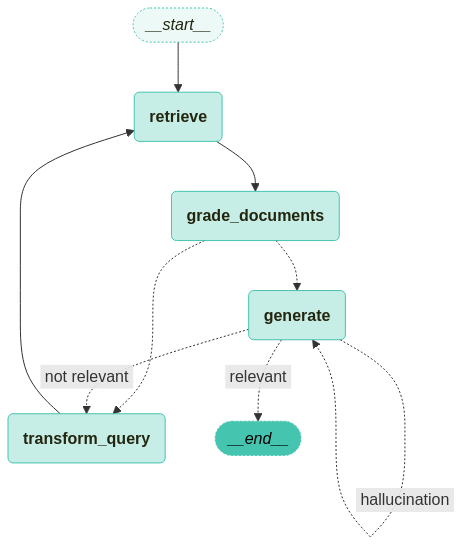

In [45]:
visualize_graph(app)

In [46]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "삼성전자가 개발한 생성형 AI 의 이름은?",
}

for event in app.stream(inputs, config=config):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)


🔄 [Node] 문서 검색 노드 🔄
문서 검색 결과: 
[Document(id='cff7cf45-9696-41fa-bd95-5f775d893031', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='SPRi AI Brief |\n2023-12월호\n삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개\nKEY Contents\nn 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성\nAI 모델 ‘삼성 가우스’를 공개\nn 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한\n삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유\n£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원'), Document(id='251e1122-45f2-410a-a961-14d4cec657e5', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542

In [47]:
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "삼성전자가 개발한 생성형 AI 의 이름은?",
}

# 스트리밍 형식으로 그래프 실행
stream_graph(
    app,
    inputs,
    config,
    ["retrieve", "grade_documents", "query_rewrite", "web_search_node", "generate"],
)


🔄 [Node] 문서 검색 노드 🔄
문서 검색 결과: 
[Document(id='cff7cf45-9696-41fa-bd95-5f775d893031', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='SPRi AI Brief |\n2023-12월호\n삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개\nKEY Contents\nn 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성\nAI 모델 ‘삼성 가우스’를 공개\nn 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한\n삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유\n£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원'), Document(id='251e1122-45f2-410a-a961-14d4cec657e5', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542

In [93]:
from langgraph.errors import GraphRecursionError

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "홍길동이 개발한 생성형 AI 의 이름은?",
}

try:
    # 그래프 실행
    stream_graph(
        app,
        inputs,
        config,
        ["retrieve", "transform_query", "grade_documents", "generate"],
    )
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


===== [RETRIEVE] retieve() 노드 실행 =====
문서 검색 결과: 
[Document(id='ea6bd0f1-69a7-4960-9c8b-158dd8d44c1e', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 11, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='제작을 포함\nn 알리바바 클라우드는 급증하는 생성 AI 수요에 대응해 모델 개발과 애플리케이션 구축 절차를\n간소화하는 올인원 AI 모델 구축 플랫폼 ‘젠AI(GenAI)’도 공개\n∙ 이 플랫폼은 데이터 관리, 모델 배포와 평가, 신속한 엔지니어링을 위한 종합 도구 모음을 제공하여\n다양한 기업들이 맞춤형 AI 모델을 한층 쉽게 개발할 수 있도록 지원\n∙ 생성 AI 개발에 필요한 컴퓨팅과 데이터 처리 요구사항을 지원하기 위해 AI 플랫폼(PAI),\n데이터베이스 솔루션, 컨테이너 서비스와 같은 클라우드 신제품도 발표'), Document(id='029d495b-b126-49e2-926d-3ea91749de71', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer'